#### Benchmaking Experiment 006b
- Model : Model4
- Dataset : PAMAP2
- Semantic Space : Glove50
- Cross Validation : 5-fold fixed classes
- Feature Loss : MSELoss

In [1]:
import os 
from datetime import date
from tqdm import tqdm
from copy import deepcopy
import numpy as np 
import pandas as pd

import torch 
from torch import nn, Tensor
from torch.nn import functional as F
from torch.nn.modules import MultiheadAttention, Linear, Dropout, BatchNorm1d, TransformerEncoderLayer
from torch.utils.data import Dataset, DataLoader
from torch.optim import Adam
from torch.nn import MSELoss

from src.datasets.data import PAMAP2Reader, DaLiAcReader, UTDReader, OPPReader
from src.datasets.dataset import PAMAP2Dataset, DaLiAcDataset, UTDDataset, OPPDataset
from src.datasets.utils import load_attribute

from src.models.ts_transformer import TSTransformerEncoderClassiregressor, RelativeGlobalAttention
from src.models.loss import FeatureLoss, AttributeLoss 

from src.utils.analysis import action_evaluator
from src.utils.distance import jaccard_neigh
# from src.running import train_step1, eval_step1

import neptune.new as neptune

In [2]:
run = neptune.init(
    project="FYP-Group22/Approach-3",
    api_token="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiJkNWJjMDdhNC05NWY5LTQwNWQtYTQyNi0zNjNmYmYwZDg3M2YifQ==",
) 

https://app.neptune.ai/FYP-Group22/Approach-3/e/APR3-30
Remember to stop your run once you’ve finished logging your metadata (https://docs.neptune.ai/api-reference/run#.stop). It will be stopped automatically only when the notebook kernel/interactive console is terminated.


In [3]:
# setup model configurations
config = {
    # general information
    "experiment-name": "Approach-3a", 
    "datetime": date.today(),
    "device": "gpu",
    "dataset": "OPP",
    "Model Core": "RelativeGlobalAttention",
    "Model Head": "Pooling",
    "sem-space": 'attr',
    # model training configs
    "include_feature_loss": True, 
    "folding": True,
    "lr": 0.001,
    "n_epochs": 9,
    "optimizer": "adam",
    "batch_size": 32,
    "feature_loss": "MSE",
    "loss_alpha": 0.3,
    "infer_dist": "jaccard",
    # model configs
    "d_model": 128, 
    "num_heads": 2,
    # dataset configs
    "window_size": 1, 
    "overlap": 0.5,
    "sample_freq": 30,
    "seen_split": 0.2,
    "unseen_split": 0.8
}

In [4]:
run['parameters'] = config

---
Model Building

In [ ]:
class Model6a(nn.Module):
    def __init__(self, in_ft, d_model, num_heads, ft_size, n_classes, max_len=1024, dropout=0.1):
        super(Model6a, self).__init__()
        self.in_ft = in_ft
        self.max_len = max_len
        self.d_model = d_model
        self.num_heads = num_heads
        self.ft_size = ft_size 
        self.n_classes = n_classes

        # feature prep layer
        self.DenseL = nn.Linear(in_ft, d_model)
        # relative global attention layer
        self.AttnL = RelativeGlobalAttention(self.d_model, self.num_heads, self.max_len)
        # positional encoding concat <-> 1DConv 
        self.Act = F.relu#_get_activation_fn(activation)
        self.AvgPoolL = nn.AvgPool2d((self.max_len,1))
        self.DenseL2 = nn.Linear(self.d_model, self.ft_size)
        self.dropout = nn.Dropout1d(dropout)
        self.logist = nn.Linear(self.ft_size, self.n_classes)

    def forward(self, x):
        out = self.DenseL(x)
        out = self.AttnL(out)
        out = self.Act(out)
        out = self.AvgPoolL(out)
        out = torch.squeeze(out)
        out = self.dropout(out)
        out1 = self.DenseL2(out)   
        out = self.logist(out1)     
        return out, out1

---

In [6]:
from sklearn.metrics import accuracy_score
from sklearn.metrics.pairwise import cosine_similarity

In [7]:
def train_step1(model, dataloader, optimizer, loss_module, device, class_names, phase='train', l2_reg=False, loss_alpha=0.7):
    model = model.train()

    epoch_loss = 0  # total loss of epoch
    total_samples = 0  # total samples in epoch

    with tqdm(dataloader, unit="batch", desc=phase) as tepoch:
        for batch in tepoch:
            X, targets, target_feat, target_attr, padding_masks = batch
            # print(X, targets, target_feat, target_attr)
            X = X.float().to(device)
            target_feat = target_feat.float().to(device)
            target_attr = target_attr.float().to(device)
            targets = targets.long().to(device)
            padding_masks = padding_masks.to(device)  # 0s: ignore

            # Zero gradients, perform a backward pass, and update the weights.
            optimizer.zero_grad()
            # forward
            # track history if only in train
            with torch.set_grad_enabled(phase == 'train'):
            # with autocast():
                class_output, feat_output = model(X)
                class_loss = loss_module['class'](class_output, targets.squeeze())
                # print(feat_output.shape, target_feat.shape)
                feat_loss = loss_module['feature'](feat_output, target_feat)

            loss = loss_alpha*class_loss+(1-loss_alpha)*feat_loss

            if phase == 'train':
                loss.backward()
                optimizer.step()

            metrics = {"loss": loss.item()}
            with torch.no_grad():
                total_samples += len(targets)
                epoch_loss += loss.item()  # add total loss of batch

            # convert feature vector into action class
            # using cosine 
            pred_class = np.argmax(class_output.cpu().detach().numpy(), axis=1)
            metrics["accuracy"] = accuracy_score(y_true=targets.cpu().detach().numpy(), y_pred=pred_class)
            tepoch.set_postfix(metrics)
            
    epoch_loss = epoch_loss / total_samples  # average loss per sample for whole epoch
    return metrics

In [8]:
def eval_step1(model, dataloader, loss_module, device, class_names, target_feat_met, phase='seen', l2_reg=False, print_report=True, show_plot=True, loss_alpha=0.7):
    model = model.train()

    epoch_loss = 0  # total loss of epoch
    total_samples = 0  # total samples in epoch
    per_batch = {'target_masks': [], 'targets': [], 'predictions': [], 'metrics': [], 'IDs': []}

    with tqdm(dataloader, unit="batch", desc=phase) as tepoch:
        for batch in tepoch:
            X, targets, target_feat, target_attr, padding_masks = batch
            X = X.float().to(device)
            target_feat = target_feat.float().to(device)
            target_attr = target_attr.float().to(device)
            targets = targets.long().to(device)
            padding_masks = padding_masks.to(device)  # 0s: ignore
            # forward
            # track history if only in train
            with torch.set_grad_enabled(phase == 'train'):
            # with autocast():
                class_output, feat_output = model(X)
                class_loss = loss_module['class'](class_output, targets.squeeze())
                feat_loss = loss_module['feature'](feat_output, target_feat)

            loss = loss_alpha*class_loss+(1-loss_alpha)*feat_loss

            # convert feature vector into action class
            # using cosine 
            if phase == 'seen':
                pred_action = np.argmax(class_output.cpu().detach().numpy(), axis=1)
            else:
                feat_numpy = torch.sigmoid(feat_output.cpu().detach())
                feat_numpy = torch.round(feat_numpy).numpy()
                # action_probs = cosine_similarity(feat_numpy, target_feat_met)
                # pred_action = np.argmax(action_probs, axis=1)
                pred_action = jaccard_neigh(feat_numpy, target_feat_met)
                
            per_batch['targets'].append(targets.cpu().numpy())
            per_batch['predictions'].append(pred_action)
            per_batch['metrics'].append([loss.cpu().numpy()])

            tepoch.set_postfix({"loss": loss.item()})
    
    all_preds = np.concatenate(per_batch["predictions"])
    all_targets = np.concatenate(per_batch["targets"])
    metrics_dict = action_evaluator(y_pred=all_preds, y_true=all_targets[:, 0], class_names=class_names, print_report=print_report, show_plot=show_plot)
    return metrics_dict

---

In [9]:
if config['device'] == 'cpu':
    device = "cpu"
else:
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [10]:
# import PAMAP2 dataset
dt = config['dataset']
if dt == 'PAMAP2':
    dataReader = PAMAP2Reader('./data/PAMAP2_Dataset/Protocol/')
elif dt == 'DaLiAc':
    dataReader = DaLiAcReader('./data/DaLiAc_Dataset/')
elif dt == 'UTD':
    dataReader = UTDReader('./data/UTD-MHAD-Inertial/')
elif dt == 'OPP':
    dataReader = OPPReader('./data/OPP_Dataset/')
actionList = dataReader.idToLabel

Reading file 1 of 20
Reading file 2 of 20
Reading file 3 of 20
Reading file 4 of 20
Reading file 5 of 20
Reading file 6 of 20
Reading file 7 of 20
Reading file 8 of 20
Reading file 9 of 20
Reading file 10 of 20
Reading file 11 of 20
Reading file 12 of 20
Reading file 13 of 20
Reading file 14 of 20
Reading file 15 of 20
Reading file 16 of 20
Reading file 17 of 20
Reading file 18 of 20
Reading file 19 of 20
Reading file 20 of 20


g:\FYP\Codebases\HAR-ZSL-XAI\src\datasets\data.py:618: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.asarray(data), np.asarray(labels, dtype=int), np.array(collection)


In [11]:
dataReader.data.shape

(979,)

In [12]:
# import PAMAP2 attributes
if dt == 'PAMAP2':   
    fpath = './data/PAMAP2_Dataset/PAMAP2_attributes.json'
elif dt == 'DaLiAc':
    fpath = './data/DaLiAc_Dataset/DaLiAc_attributes.json'
elif dt == 'UTD':
    fpath = './data/UTD-MHAD-Inertial/UTD_attributes.json'
elif dt == 'OPP':
    fpath = './data/OPP_Dataset/OPP_Attributes.json'

activity_dict, attribute_dict, attr_mat = load_attribute(fpath)
_, attr_size = attr_mat.shape

In [13]:
# Load semantic feature space 
st = config['sem-space']
if dt == 'PAMAP2':
    if st == 'glove50-v1':
        fpath = './data/PAMAP2_Dataset/glove_features.npy'
    elif st == 'glove50-v2':
        fpath = './data/PAMAP2_Dataset/glove_featureV2.npy'
    elif st == 'video-V1':
        fpath = './data/PAMAP2_Dataset/video_pca_ft.npy'
    elif st == 'word2vec-v1':
        fpath = './data/PAMAP2_Dataset/word2vec_features.npy'
    elif st == 'word2vec-v2':
        fpath = './data/PAMAP2_Dataset/word2vec_featureV2.npy'
    elif st == 'attr':
        fpath = './data/PAMAP2_Dataset/attribute_ft.npy'
elif dt == 'DaLiAc':
    if st == 'glove50-v1':
        pass 
    elif st == 'attr':
        fpath = './data/DaLiAc_Dataset/attribute_ft.npy'
elif dt == 'UTD':
    if st == 'glove50-v1':
        pass 
    elif st == 'attr':
        fpath = './data/UTD-MHAD-Inertial/attribute_ft.npy'
elif dt == 'OPP':
    if st == 'glove50-v1':
        pass 
    elif st == 'attr':
        fpath = './data/OPP_Dataset/attribute_ft.npy'

feat_mat = np.load(fpath)
n_actions, feat_size = feat_mat.shape

In [14]:
# run 5-fold running
if dt == 'PAMAP2':
    fold_classes = [['watching TV', 'house cleaning', 'standing', 'ascending stairs'], ['walking', 'rope jumping', 'sitting', 'descending stairs'], ['playing soccer', 'lying', 'vacuum cleaning', 'computer work'], ['cycling', 'running', 'Nordic walking'], ['ironing', 'car driving', 'folding laundry']]
elif dt == 'DaLiAc':
    fold_classes = [['sitting', 'vacuuming', 'descending stairs'], ['lying', 'sweeping', 'treadmill running'], ['standing', 'walking', 'cycling'], ['washing dishes', 'ascending stairs', 'rope jumping']]
elif dt == 'UTD':
    fold_classes = [['swipe left', 'cross arms', 'draw triangle', 'arm curl', 'jogging in place', 'pick up then throw'], ['swipe right', 'basketball shoot', 'bowling', 'tennis serve', 'walking in place', 'squat'], ['wave', 'draw x', 'boxing', 'two hand push', 'sit to stand'], ['clap', 'draw circle clockwise', 'baseball swing', 'knock', 'stand to sit'], ['throw', 'draw circle counter clockwise', 'tennis swing', 'catch', 'lunge']]
elif dt == 'OPP':
    fold_classes = [['Close Drawer 2', 'Clean Table', 'Toggle Switch', 'Open Drawer 3'], ['Open Fridge', 'Open Door 2', 'Close Drawer 1', 'Open Drawer 2'], ['Drink from Cup', 'Open Drawer 1', 'Close Dishwasher'], ['Close Drawer 3', 'Close Door 2', 'Open Door 1'], ['Close Fridge', 'Open Dishwasher', 'Close Door 1']]

fold_cls_ids = [[actionList.index(i) for i in j] for j in fold_classes]

In [15]:
if config['dataset'] == 'PAMAP2':
    dts = PAMAP2Dataset
elif config['dataset'] == 'DaLiAc':
    dts = DaLiAcDataset
elif config['dataset'] == 'UTD':
    dts = UTDDataset
elif config['dataset'] == 'OPP':
    dts = OPPDataset

In [16]:
data_dict = dataReader.generate(unseen_classes=fold_cls_ids[0], seen_ratio=0.2, unseen_ratio=0.8, window_size=1, window_overlap=0.5, resample_freq=30)
sample_dt = dts(data=data_dict['train']['X'], actions=data_dict['train']['y'], attributes=attr_mat, action_feats=feat_mat, action_classes=data_dict['seen_classes'], seq_len=100)
sample_dl = DataLoader(sample_dt, batch_size=32, shuffle=True, pin_memory=True, drop_last=True)
for d in sample_dl:
    print(d[0].shape, torch.isnan(d[0]).numpy().mean())
    break

data shape : (979,), seen_data shape : (790,)
{'Open Door 1': 45, 'Open Door 2': 43, 'Close Door 1': 38, 'Close Door 2': 40, 'Open Fridge': 129, 'Close Fridge': 131, 'Open Dishwasher': 54, 'Close Dishwasher': 53, 'Open Drawer 1': 50, 'Close Drawer 1': 49, 'Open Drawer 2': 45, 'Close Drawer 2': 44, 'Open Drawer 3': 56, 'Close Drawer 3': 57, 'Clean Table': 17, 'Drink from Cup': 56, 'Toggle Switch': 72}
torch.Size([32, 30, 96]) 0.0


In [17]:
data_dict['train']['X'].shape

(3199, 30, 96)

In [18]:
np.isnan(data_dict['train']['X']).mean()

0.0

In [19]:
def log(fold, phase, metrics):
    for m, v in metrics.items():
        if fold == 'global':
            run[f'global/{m}'].log(v)
        else:
            run[f"Fold-{fold}/{phase}/{m}"].log(v) 

================ Fold-0 ================
Unseen Classes : ['Close Drawer 2', 'Clean Table', 'Toggle Switch', 'Open Drawer 3']
data shape : (979,), seen_data shape : (790,)
{'Open Door 1': 45, 'Open Door 2': 43, 'Close Door 1': 38, 'Close Door 2': 40, 'Open Fridge': 129, 'Close Fridge': 131, 'Open Dishwasher': 54, 'Close Dishwasher': 53, 'Open Drawer 1': 50, 'Close Drawer 1': 49, 'Open Drawer 2': 45, 'Close Drawer 2': 44, 'Open Drawer 3': 56, 'Close Drawer 3': 57, 'Clean Table': 17, 'Drink from Cup': 56, 'Toggle Switch': 72}


seen: 100%|██████████| 25/25 [00:00<00:00, 62.97batch/s, loss=74.7]


Overall accuracy: 0.125



Training Epoch:  11%|█         | 1/9 [00:12<01:37, 12.24s/it]

Overall accuracy: 0.281



seen: 100%|██████████| 25/25 [00:00<00:00, 54.11batch/s, loss=29.1]


Overall accuracy: 0.161



Training Epoch:  22%|██▏       | 2/9 [00:18<01:01,  8.84s/it]

Overall accuracy: 0.327



seen: 100%|██████████| 25/25 [00:00<00:00, 51.13batch/s, loss=9.42]


Overall accuracy: 0.302



Training Epoch:  33%|███▎      | 3/9 [00:25<00:46,  7.81s/it]

Overall accuracy: 0.330



seen: 100%|██████████| 25/25 [00:00<00:00, 54.38batch/s, loss=10.1]


Overall accuracy: 0.350



Training Epoch:  44%|████▍     | 4/9 [00:31<00:36,  7.21s/it]

Overall accuracy: 0.336



seen: 100%|██████████| 25/25 [00:00<00:00, 51.44batch/s, loss=4.95]


Overall accuracy: 0.367



Training Epoch:  56%|█████▌    | 5/9 [00:37<00:27,  6.90s/it]

Overall accuracy: 0.303



seen: 100%|██████████| 25/25 [00:00<00:00, 44.56batch/s, loss=2.59]


Overall accuracy: 0.385



Training Epoch:  67%|██████▋   | 6/9 [00:45<00:21,  7.05s/it]

Overall accuracy: 0.300



seen: 100%|██████████| 25/25 [00:00<00:00, 48.87batch/s, loss=1.97]


Overall accuracy: 0.390



Training Epoch:  78%|███████▊  | 7/9 [00:51<00:13,  6.90s/it]

Overall accuracy: 0.308



seen: 100%|██████████| 25/25 [00:00<00:00, 38.28batch/s, loss=3.41]


Overall accuracy: 0.398



Training Epoch:  89%|████████▉ | 8/9 [00:59<00:07,  7.04s/it]

Overall accuracy: 0.303



seen: 100%|██████████| 25/25 [00:00<00:00, 44.25batch/s, loss=1.44]


Overall accuracy: 0.391



unseen: 100%|██████████| 20/20 [00:03<00:00,  5.99batch/s, loss=7.23]


Overall accuracy: 0.312



unseen: 100%|██████████| 20/20 [00:02<00:00,  6.83batch/s, loss=2.12]


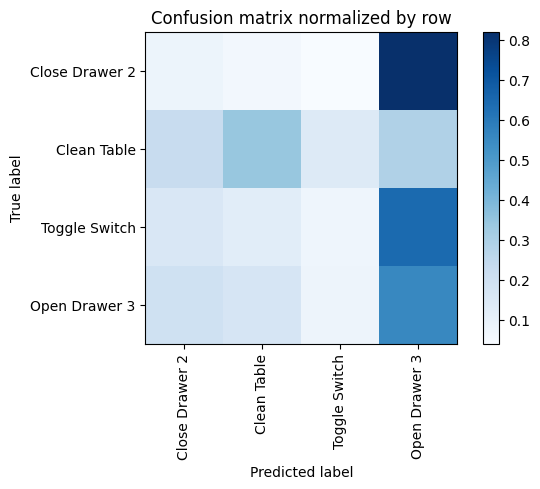

Overall accuracy: 0.311

                 precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

   Clean Table       0.761      0.344      0.474      0.550        352|	 Open Drawer 3: 0.290,	Close Drawer 2: 0.227,	
 Toggle Switch       0.130      0.074      0.095      0.189        121|	 Open Drawer 3: 0.645,	Close Drawer 2: 0.157,	Clean Table: 0.124,	
 Open Drawer 3       0.227      0.556      0.323      0.183        117|	 Close Drawer 2: 0.197,	Clean Table: 0.171,	
Close Drawer 2       0.032      0.080      0.045      0.078         50|	 Open Drawer 3: 0.820,	Clean Table: 0.060,	

----------------------------------------------------------------------------------------------------
   avg / total       0.487      0.311      0.341        1.0        640|	      

{'total_accuracy': 0.3109375, 'precision': 0.2876149577339077, 'recall': 0.26342143021120296, 'f1': 0.23408831150708492}
================ Fold-1 ================
Unseen Classes : ['Open Fridge', 'Open Door 2', 'C

seen: 100%|██████████| 23/23 [00:00<00:00, 47.51batch/s, loss=92.6]


Overall accuracy: 0.088



Training Epoch:  11%|█         | 1/9 [00:07<00:59,  7.39s/it]

Overall accuracy: 0.411



seen: 100%|██████████| 23/23 [00:00<00:00, 72.33batch/s, loss=37.6]


Overall accuracy: 0.090



Training Epoch:  22%|██▏       | 2/9 [00:13<00:45,  6.52s/it]

Overall accuracy: 0.391



seen: 100%|██████████| 23/23 [00:00<00:00, 89.84batch/s, loss=10.7]


Overall accuracy: 0.114



Training Epoch:  33%|███▎      | 3/9 [00:19<00:37,  6.26s/it]

Overall accuracy: 0.354



seen: 100%|██████████| 23/23 [00:00<00:00, 86.79batch/s, loss=9.63]


Overall accuracy: 0.144



Training Epoch:  44%|████▍     | 4/9 [00:25<00:30,  6.12s/it]

Overall accuracy: 0.344



seen: 100%|██████████| 23/23 [00:00<00:00, 78.50batch/s, loss=2.59]


Overall accuracy: 0.314



Training Epoch:  56%|█████▌    | 5/9 [00:31<00:24,  6.17s/it]

Overall accuracy: 0.347



seen: 100%|██████████| 23/23 [00:00<00:00, 77.97batch/s, loss=2.64]


Overall accuracy: 0.357



Training Epoch:  67%|██████▋   | 6/9 [00:37<00:18,  6.15s/it]

Overall accuracy: 0.343



seen: 100%|██████████| 23/23 [00:00<00:00, 77.97batch/s, loss=3.39]


Overall accuracy: 0.383



Training Epoch:  78%|███████▊  | 7/9 [00:43<00:12,  6.19s/it]

Overall accuracy: 0.365



seen: 100%|██████████| 23/23 [00:00<00:00, 77.86batch/s, loss=3.88]


Overall accuracy: 0.389



Training Epoch:  89%|████████▉ | 8/9 [00:50<00:06,  6.20s/it]

Overall accuracy: 0.345



seen: 100%|██████████| 23/23 [00:00<00:00, 76.16batch/s, loss=1.81]


Overall accuracy: 0.387



unseen: 100%|██████████| 27/27 [00:04<00:00,  6.06batch/s, loss=0.953]


Overall accuracy: 0.356



unseen: 100%|██████████| 27/27 [00:04<00:00,  6.35batch/s, loss=1.1] 


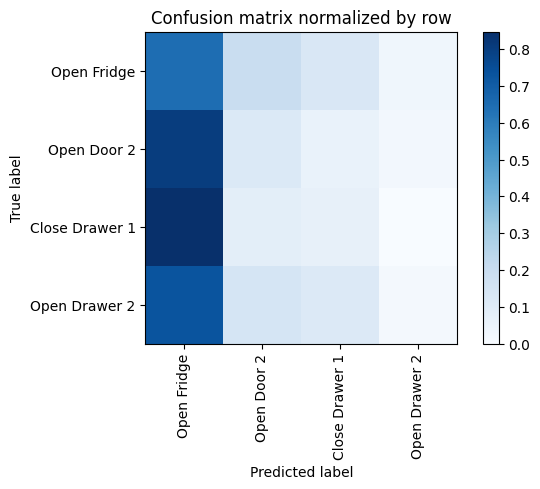

Overall accuracy: 0.368

                 precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

   Open Fridge       0.444      0.647      0.527      0.495        428|	 Open Door 2: 0.196,	Close Drawer 1: 0.126,	
   Open Door 2       0.267      0.117      0.163      0.355        307|	 Open Fridge: 0.801,	Close Drawer 1: 0.059,	
 Open Drawer 2       0.048      0.014      0.022      0.081         70|	 Open Fridge: 0.729,	Open Door 2: 0.143,	Close Drawer 1: 0.114,	
Close Drawer 1       0.048      0.068      0.056      0.068         59|	 Open Fridge: 0.847,	Open Door 2: 0.085,	

----------------------------------------------------------------------------------------------------
   avg / total       0.322      0.368      0.324 0.9999999999999999        864|	      

{'total_accuracy': 0.3680555555555556, 'precision': 0.20145375457875458, 'recall': 0.2116356074464143, 'f1': 0.1918584937764092}
================ Fold-2 ================
Unseen Classes : ['Drink from Cup', 'Ope

seen: 100%|██████████| 18/18 [00:00<00:00, 87.80batch/s, loss=153]


Overall accuracy: 0.095



Training Epoch:  11%|█         | 1/9 [00:08<01:04,  8.11s/it]

Overall accuracy: 0.741



seen: 100%|██████████| 18/18 [00:00<00:00, 74.38batch/s, loss=69]


Overall accuracy: 0.123



Training Epoch:  22%|██▏       | 2/9 [00:16<00:56,  8.04s/it]

Overall accuracy: 0.702



seen: 100%|██████████| 18/18 [00:00<00:00, 95.74batch/s, loss=14.6]


Overall accuracy: 0.132



Training Epoch:  33%|███▎      | 3/9 [00:24<00:48,  8.06s/it]

Overall accuracy: 0.709



seen: 100%|██████████| 18/18 [00:00<00:00, 96.25batch/s, loss=17.8] 


Overall accuracy: 0.146



Training Epoch:  44%|████▍     | 4/9 [00:32<00:40,  8.04s/it]

Overall accuracy: 0.711



seen: 100%|██████████| 18/18 [00:00<00:00, 77.59batch/s, loss=5.14]


Overall accuracy: 0.148



Training Epoch:  56%|█████▌    | 5/9 [00:40<00:31,  7.96s/it]

Overall accuracy: 0.726



seen: 100%|██████████| 18/18 [00:00<00:00, 64.98batch/s, loss=4.82]


Overall accuracy: 0.137



Training Epoch:  67%|██████▋   | 6/9 [00:48<00:24,  8.06s/it]

Overall accuracy: 0.712



seen: 100%|██████████| 18/18 [00:00<00:00, 94.24batch/s, loss=3]


Overall accuracy: 0.155



Training Epoch:  78%|███████▊  | 7/9 [00:56<00:15,  7.97s/it]

Overall accuracy: 0.742



seen: 100%|██████████| 18/18 [00:00<00:00, 89.11batch/s, loss=5.96]


Overall accuracy: 0.151



Training Epoch:  89%|████████▉ | 8/9 [01:03<00:07,  7.93s/it]

Overall accuracy: 0.743



seen: 100%|██████████| 18/18 [00:00<00:00, 89.11batch/s, loss=1.88]


Overall accuracy: 0.153



unseen: 100%|██████████| 53/53 [00:06<00:00,  8.15batch/s, loss=33.5]


Overall accuracy: 0.744



unseen: 100%|██████████| 53/53 [00:06<00:00,  8.51batch/s, loss=54]  


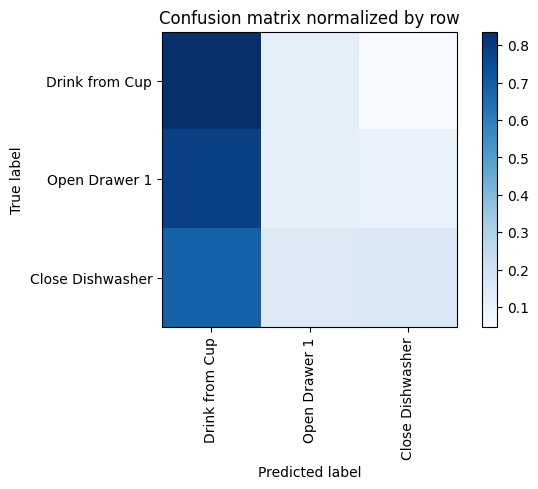

Overall accuracy: 0.744

                   precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

  Drink from Cup       0.884      0.835      0.859      0.867       1471|	 Open Drawer 1: 0.117,	Close Dishwasher: 0.048,	
Close Dishwasher       0.235      0.164      0.194      0.086        146|	 Drink from Cup: 0.685,	Open Drawer 1: 0.151,	
   Open Drawer 1       0.044      0.114      0.064      0.047         79|	 Drink from Cup: 0.785,	Close Dishwasher: 0.101,	

----------------------------------------------------------------------------------------------------
     avg / total       0.789      0.744      0.765        1.0       1696|	      

{'total_accuracy': 0.7441037735849056, 'precision': 0.3877220389134855, 'recall': 0.37126455872628483, 'f1': 0.37207271545944526}
================ Fold-3 ================
Unseen Classes : ['Close Drawer 3', 'Close Door 2', 'Open Door 1']
data shape : (979,), seen_data shape : (837,)
{'Open Door 1': 45, 'Open Door 2': 43, 'Close D

seen: 100%|██████████| 25/25 [00:00<00:00, 86.51batch/s, loss=55.6]


Overall accuracy: 0.117



Training Epoch:  11%|█         | 1/9 [00:04<00:35,  4.43s/it]

Overall accuracy: 0.298



seen: 100%|██████████| 25/25 [00:00<00:00, 73.31batch/s, loss=7.16]


Overall accuracy: 0.233



Training Epoch:  22%|██▏       | 2/9 [00:08<00:31,  4.46s/it]

Overall accuracy: 0.241



seen: 100%|██████████| 25/25 [00:00<00:00, 88.65batch/s, loss=2.99]


Overall accuracy: 0.307



Training Epoch:  33%|███▎      | 3/9 [00:13<00:26,  4.45s/it]

Overall accuracy: 0.269



seen: 100%|██████████| 25/25 [00:00<00:00, 87.11batch/s, loss=1.6]


Overall accuracy: 0.328



Training Epoch:  44%|████▍     | 4/9 [00:17<00:22,  4.43s/it]

Overall accuracy: 0.308



seen: 100%|██████████| 25/25 [00:00<00:00, 77.88batch/s, loss=1.05]


Overall accuracy: 0.335



Training Epoch:  56%|█████▌    | 5/9 [00:22<00:17,  4.44s/it]

Overall accuracy: 0.320



seen: 100%|██████████| 25/25 [00:00<00:00, 93.28batch/s, loss=1.29]


Overall accuracy: 0.355



Training Epoch:  67%|██████▋   | 6/9 [00:26<00:13,  4.46s/it]

Overall accuracy: 0.320



seen: 100%|██████████| 25/25 [00:00<00:00, 77.40batch/s, loss=0.986]


Overall accuracy: 0.362



Training Epoch:  78%|███████▊  | 7/9 [00:31<00:08,  4.42s/it]

Overall accuracy: 0.317



seen: 100%|██████████| 25/25 [00:00<00:00, 87.41batch/s, loss=1.12]


Overall accuracy: 0.370



Training Epoch:  89%|████████▉ | 8/9 [00:35<00:04,  4.51s/it]

Overall accuracy: 0.308



seen: 100%|██████████| 25/25 [00:00<00:00, 73.31batch/s, loss=1.94]


Overall accuracy: 0.371



unseen: 100%|██████████| 20/20 [00:02<00:00,  7.82batch/s, loss=22.1]


Overall accuracy: 0.327



unseen: 100%|██████████| 20/20 [00:02<00:00,  8.42batch/s, loss=3.25] 


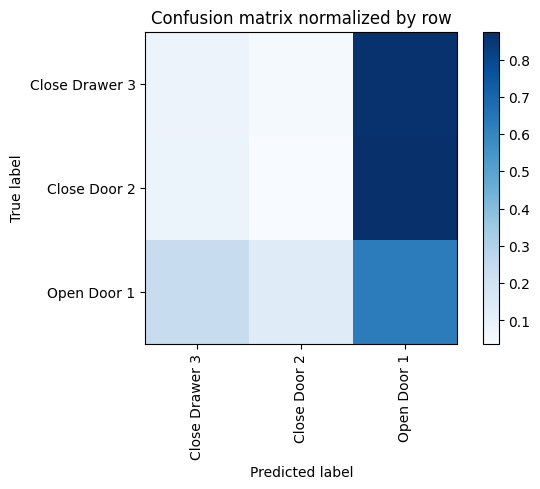

Overall accuracy: 0.319

                 precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

   Open Door 1       0.384      0.626      0.476      0.464        297|	 Close Drawer 3: 0.236,	Close Door 2: 0.138,	
  Close Door 2       0.164      0.038      0.061      0.373        239|	 Open Door 1: 0.874,	Close Drawer 3: 0.088,	
Close Drawer 3       0.090      0.087      0.088      0.163        104|	 Open Door 1: 0.865,	Close Door 2: 0.048,	

----------------------------------------------------------------------------------------------------
   avg / total       0.254      0.319      0.258        1.0        640|	      

{'total_accuracy': 0.31875, 'precision': 0.2123805060918463, 'recall': 0.2501526638555927, 'f1': 0.20838770290724987}
================ Fold-4 ================
Unseen Classes : ['Close Fridge', 'Open Dishwasher', 'Close Door 1']
data shape : (979,), seen_data shape : (756,)
{'Open Door 1': 45, 'Open Door 2': 43, 'Close Door 1': 38, 'Close Door 2': 40, 

seen: 100%|██████████| 24/24 [00:00<00:00, 37.02batch/s, loss=72.4]


Overall accuracy: 0.098



Training Epoch:  11%|█         | 1/9 [00:06<00:55,  6.97s/it]

Overall accuracy: 0.375



seen: 100%|██████████| 24/24 [00:00<00:00, 91.60batch/s, loss=19]


Overall accuracy: 0.168



Training Epoch:  22%|██▏       | 2/9 [00:11<00:40,  5.79s/it]

Overall accuracy: 0.382



seen: 100%|██████████| 24/24 [00:00<00:00, 29.47batch/s, loss=9.18]


Overall accuracy: 0.257



Training Epoch:  33%|███▎      | 3/9 [00:19<00:40,  6.69s/it]

Overall accuracy: 0.389



seen: 100%|██████████| 24/24 [00:00<00:00, 89.22batch/s, loss=2.25]


Overall accuracy: 0.326



Training Epoch:  44%|████▍     | 4/9 [00:24<00:29,  5.98s/it]

Overall accuracy: 0.389



seen: 100%|██████████| 24/24 [00:00<00:00, 92.66batch/s, loss=3.63]


Overall accuracy: 0.372



Training Epoch:  56%|█████▌    | 5/9 [00:29<00:22,  5.57s/it]

Overall accuracy: 0.405



seen: 100%|██████████| 24/24 [00:00<00:00, 71.85batch/s, loss=3.02]


Overall accuracy: 0.384



Training Epoch:  67%|██████▋   | 6/9 [00:35<00:17,  5.79s/it]

Overall accuracy: 0.385



seen: 100%|██████████| 24/24 [00:00<00:00, 71.71batch/s, loss=4.47]


Overall accuracy: 0.388



Training Epoch:  78%|███████▊  | 7/9 [00:41<00:11,  5.81s/it]

Overall accuracy: 0.402



seen: 100%|██████████| 24/24 [00:00<00:00, 89.89batch/s, loss=1.69]


Overall accuracy: 0.380



Training Epoch:  89%|████████▉ | 8/9 [00:46<00:05,  5.57s/it]

Overall accuracy: 0.397



seen: 100%|██████████| 24/24 [00:00<00:00, 67.21batch/s, loss=0.916]


Overall accuracy: 0.396



unseen: 100%|██████████| 23/23 [00:03<00:00,  6.97batch/s, loss=2.61]


Overall accuracy: 0.385



unseen: 100%|██████████| 23/23 [00:02<00:00,  7.85batch/s, loss=8.28]


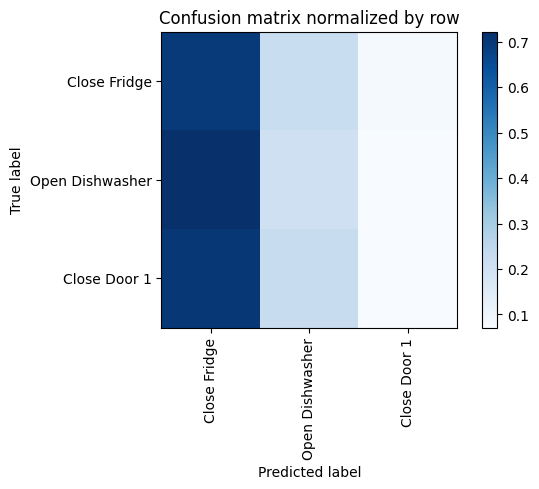

Overall accuracy: 0.402

                  precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

   Close Fridge       0.478      0.699      0.568      0.482        355|	 Open Dishwasher: 0.223,	Close Door 1: 0.079,	
   Close Door 1       0.291      0.071      0.114      0.307        226|	 Close Fridge: 0.704,	Open Dishwasher: 0.226,	
Open Dishwasher       0.198      0.206      0.202      0.211        155|	 Close Fridge: 0.723,	Close Door 1: 0.071,	

----------------------------------------------------------------------------------------------------
    avg / total       0.361      0.402      0.351        1.0        736|	      

{'total_accuracy': 0.40217391304347827, 'precision': 0.3220939863200621, 'recall': 0.3252798741253305, 'f1': 0.29442582295400427}
============== Overall Unseen Classes Performance ==============
Shutting down background jobs, please wait a moment...
Done!
Waiting for the remaining 36 operations to synchronize with Neptune. Do not kill this pr

In [21]:
fold_metric_scores = []
for i, cs in enumerate(fold_cls_ids):
    print("="*16, f'Fold-{i}', "="*16)
    # print(f'Unseen Classes : {fold_classes[i]}')
    # separate seen/unseen and train/eval 
    data_dict = dataReader.generate(unseen_classes=cs, seen_ratio=config['seen_split'], unseen_ratio=config['unseen_split'], window_size=config['window_size'], window_overlap=config['overlap'], resample_freq=config['sample_freq'])
    all_classes = dataReader.idToLabel
    seen_classes = data_dict['seen_classes']
    unseen_classes = data_dict['unseen_classes']
    # print("seen classes > ", seen_classes)
    # print("unseen classes > ", unseen_classes)
    if dt == 'UTD':
        train_n = len(data_dict['train']['X'])
        seq_len, in_ft = 100, 6

    else:
        train_n, seq_len, in_ft = data_dict['train']['X'].shape
    # build train_dt 
    # print(seen_classes)
    train_dt = dts(data=data_dict['train']['X'], actions=data_dict['train']['y'], attributes=attr_mat, action_feats=feat_mat, action_classes=seen_classes, seq_len=100)
    train_dl = DataLoader(train_dt, batch_size=config['batch_size'], shuffle=True, pin_memory=True, drop_last=True)
    # build seen eval_dt 
    eval_dt = dts(data=data_dict['eval-seen']['X'], actions=data_dict['eval-seen']['y'], attributes=attr_mat, action_feats=feat_mat, action_classes=seen_classes, seq_len=100)
    eval_dl = DataLoader(eval_dt, batch_size=config['batch_size'], shuffle=True, pin_memory=True, drop_last=True)
    # build unseen test_dt
    test_dt = dts(data=data_dict['test']['X'], actions=data_dict['test']['y'], attributes=attr_mat, action_feats=feat_mat, action_classes=unseen_classes, seq_len=100)
    test_dl = DataLoader(test_dt, batch_size=config['batch_size'], shuffle=True, pin_memory=True, drop_last=True)
    
    # build model
    model = Model6a(in_ft=in_ft, d_model=config['d_model'], num_heads=config['num_heads'], ft_size=feat_size, max_len=seq_len, n_classes=len(seen_classes))
    # model = Model1(feat_dim=in_ft, max_len=seq_len, d_model=config['d_model'], n_heads=config['num_heads'], num_layers=2, dim_feedforward=128, ft_size=feat_size)
    model.to(device)
    # define run parameters 
    optimizer = Adam(model.parameters(), lr=config['lr'])
    loss_module = {'class': nn.CrossEntropyLoss(), 'feature': MSELoss()}
    best_acc = 0.0
    # train the model 
    for epoch in tqdm(range(config['n_epochs']), desc='Training Epoch', leave=False):
        train_metrics = train_step1(model, train_dl, optimizer, loss_module, device, class_names=[all_classes[i] for i in seen_classes], phase='train', loss_alpha=config['loss_alpha'])
        log(i, 'train', train_metrics)
        eval_metrics = eval_step1(model, eval_dl, loss_module, device, class_names=[all_classes[i] for i in seen_classes],  target_feat_met=eval_dt.target_feat, phase='seen', print_report=False, loss_alpha=config['loss_alpha'], show_plot=False)
        log(i, 'seen-eval', eval_metrics)

        ueval_metrics = eval_step1(model, test_dl, loss_module, device, class_names=[all_classes[i] for i in unseen_classes],  target_feat_met=test_dt.target_feat, phase='unseen', print_report=False, loss_alpha=config['loss_alpha'], show_plot=False)
        log(i, 'unseen-eval', ueval_metrics)
        # print(f"EPOCH [{epoch}] TRAINING : {train_metrics}")
        # print(f"EPOCH [{epoch}] EVAL : {eval_metrics}")
        if eval_metrics['total_accuracy'] > best_acc:
            best_model = deepcopy(model.state_dict())
    
    if best_acc == 0.0:
        best_model = deepcopy(model.state_dict())
    
    # replace by best model 
    model.load_state_dict(best_model)

    # run evaluation on unseen classes
    test_metrics = eval_step1(model, test_dl, loss_module, device, class_names=[all_classes[i] for i in unseen_classes],  target_feat_met=test_dt.target_feat, phase='unseen', loss_alpha=config['loss_alpha'])
    fold_metric_scores.append(test_metrics)
    log('test', i, test_metrics)
    print(test_metrics)
    print("="*40)
    
print("="*14, "Overall Unseen Classes Performance", "="*14)
seen_score_df = pd.DataFrame.from_records(fold_metric_scores)
seen_score_df.mean()
log('global', '',seen_score_df.mean().to_dict())
run.stop()